# Robust LightGCN Pipeline

A modular, date-driven LightGCN implementation for fund-stock relationship prediction.

## Features:
- **Date-driven**: Change `TARGET_DATE` to run the pipeline for any date
- **Dual data sources**: Load from database or parquet files
- **Modular design**: All functions are reusable and well-organized
- **Complete pipeline**: Single `run_pipeline()` call runs everything

## 1. Configuration

Modify these parameters to customize the pipeline.

In [8]:
# ==============================================================================
# CONFIGURATION - Modify these parameters as needed
# ==============================================================================

# Data Source Configuration
DATA_SOURCE = "parquet"  # Options: "database" or "parquet"
PARQUET_DIR = "../../Data/parquet_files"  # Relative path to parquet files
TARGET_DATE = "2024-01-01"  # Date in YYYY-MM-DD format
ENV_PATH = r"C:\Users\potda\Daniel\BGU\Year_D\Final_Project\Social-Network-Stock-Market\.env"
# Model Hyperparameters
EMBEDDING_DIM = 128
NUM_LAYERS = 3
EPOCHS = 50
LEARNING_RATE = 0.001

# Train/Val/Test Split Ratios
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

# Training Configuration
EARLY_STOPPING_PATIENCE = 10
RANDOM_SEED = 42

# Evaluation Configuration
TOP_K_VALUES = [5, 10, 20, 50]

# Model Saving
SAVE_MODEL = True
MODEL_SAVE_DIR = "./models"

## 2. Imports and Environment Setup

In [9]:
# Core libraries
import pandas as pd
import numpy as np
import os
import sys
import random
from datetime import datetime
import warnings
from pathlib import Path
import glob

# Graph libraries
import networkx as nx

# Machine learning libraries
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score,
    precision_recall_curve, average_precision_score
)

# Deep learning libraries
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv

# Progress tracking
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

print("✓ Imports complete")

✓ Imports complete


In [10]:
# Environment Setup
from dotenv import load_dotenv

# Try to load .env from multiple locations
env_paths = [
    Path(ENV_PATH),
    Path.cwd() / '.env',
    Path.cwd().parent / '.env',
    Path.cwd().parent.parent / '.env',
]

for env_path in env_paths:
    if env_path.exists():
        load_dotenv(env_path)
        print(f"✓ Loaded environment from: {env_path}")
        break
else:
    print("⚠ No .env file found - database connection may fail")

# Calculate project root path
notebook_path = Path.cwd()
project_root = notebook_path.parent.parent

# Add project root to Python path
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"✓ Project root: {project_root}")

✓ Loaded environment from: C:\Users\potda\Daniel\BGU\Year_D\Final_Project\Social-Network-Stock-Market\.env
✓ Project root: c:\Users\potda\Daniel\BGU\Year_D\Final_Project\Social-Network-Stock-Market


In [11]:
# ==============================================================================
# GPU/Device Setup
# ==============================================================================

def get_device():
    """Get available device (CUDA if available, else CPU)."""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"✓ Using GPU: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device('cpu')
        print("✓ Using CPU")
    return device

# Set device
DEVICE = get_device()
print(f"PyTorch Version: {torch.__version__}")

✓ Using GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU
PyTorch Version: 2.6.0+cu124


## 3. Data Loading Functions

In [12]:
# Data Loading Functions

def validate_date_format(date_str: str) -> bool:
    """Validate date format is YYYY-MM-DD."""
    try:
        datetime.strptime(date_str, '%Y-%m-%d')
        return True
    except ValueError:
        return False


def load_holdings_from_database(date: str) -> pd.DataFrame:
    """
    Load holdings data from PostgreSQL database for a specific date.
    
    Args:
        date: Date string in YYYY-MM-DD format
        
    Returns:
        DataFrame with columns: nameofissuer, cusip, sshprnamt, cik, period_start, price
    """
    from ETL.data_handlers.db_data_handler.postgres_handler import PostgresHandler
    
    # Connect to database
    handler = PostgresHandler()
    
    if not handler.connect():
        raise ConnectionError("Failed to connect to database")
    
    # Query with parameterized date
    query = f"""
    SELECT 
        hf.nameofissuer,
        hf.cusip,
        hf.sshprnamt,
        hf.cik,
        hf.period_start,
        tp.price
    FROM holdings_filtered_new hf
    INNER JOIN ticker_to_cusip ttc ON hf.cusip = ttc.cusip
    INNER JOIN ticker_prices tp ON ttc.ticker = tp.ticker 
        AND hf.period_start = CAST(tp.period_start AS DATE)
    WHERE hf.period_start = '{date}'
    """
    
    df = pd.read_sql_query(query, handler.connection)
    
    # Close connection
    handler.disconnect()
    
    if len(df) == 0:
        raise ValueError(f"No data found for date: {date}")
    
    return df


def load_holdings_from_parquet(date: str, parquet_dir: str) -> pd.DataFrame:
    """
    Load holdings data from parquet files for a specific date.
    
    Supports file naming conventions:
        - holdings_filtered_new_period_start_{YYYY-MM-DD}.parquet
        - holdings_{YYYY-MM-DD}.parquet
        - {YYYY-MM-DD}.parquet
    
    Args:
        date: Date string in YYYY-MM-DD format
        parquet_dir: Path to directory containing parquet files
        
    Returns:
        DataFrame with holdings data
    """
    # Resolve parquet directory path
    parquet_path = Path(parquet_dir)
    if not parquet_path.is_absolute():
        parquet_path = Path.cwd() / parquet_dir
    
    if not parquet_path.exists():
        raise FileNotFoundError(f"Parquet directory not found: {parquet_path}")
    
    # Try different naming conventions
    naming_patterns = [
        f"holdings_filtered_new_period_start_{date}.parquet",
        f"holdings_{date}.parquet",
        f"{date}.parquet",
        f"holdings_filtered_new_period_start_{date.replace('-', '_')}.parquet",
    ]
    
    parquet_file = None
    for pattern in naming_patterns:
        potential_file = parquet_path / pattern
        if potential_file.exists():
            parquet_file = potential_file
            break
    
    if parquet_file is None:
        # Try to find any file containing the date
        matching_files = list(parquet_path.glob(f"*{date}*.parquet"))
        if matching_files:
            parquet_file = matching_files[0]
        else:
            available_files = list(parquet_path.glob("*.parquet"))
            raise FileNotFoundError(
                f"No parquet file found for date {date}. "
                f"Available files: {[f.name for f in available_files[:5]]}..."
            )
    
    # Load the parquet file
    with tqdm(total=1, desc=f"Loading {parquet_file.name}") as pbar:
        df = pd.read_parquet(parquet_file)
        pbar.update(1)
    
    # Also load ticker_prices and ticker_to_cusip for price information
    ticker_prices_file = parquet_path / "ticker_prices.parquet"
    ticker_to_cusip_file = parquet_path / "ticker_to_cusip.parquet"
    
    if 'price' not in df.columns and ticker_prices_file.exists() and ticker_to_cusip_file.exists():
        with tqdm(total=2, desc="Loading price data") as pbar:
            ticker_prices = pd.read_parquet(ticker_prices_file)
            pbar.update(1)
            ticker_to_cusip = pd.read_parquet(ticker_to_cusip_file)
            pbar.update(1)
        
        # Merge to get prices
        df = df.merge(ticker_to_cusip, on='cusip', how='inner')
        
        # Convert period_start to proper date format for merging
        if 'period_start' in ticker_prices.columns:
            ticker_prices['period_start'] = pd.to_datetime(ticker_prices['period_start']).dt.date
        if 'period_start' in df.columns:
            df['period_start'] = pd.to_datetime(df['period_start']).dt.date
        
        df = df.merge(
            ticker_prices[['ticker', 'period_start', 'price']], 
            on=['ticker', 'period_start'], 
            how='inner'
        )
    
    if len(df) == 0:
        raise ValueError(f"No data found for date: {date}")
    
    return df


def load_holdings_data(date: str, data_source: str, parquet_dir: str = None) -> pd.DataFrame:
    """
    Unified interface to load holdings data from either database or parquet.
    
    Args:
        date: Date string in YYYY-MM-DD format
        data_source: "database" or "parquet"
        parquet_dir: Path to parquet files (required if data_source is "parquet")
        
    Returns:
        DataFrame with holdings data
    """
    # Validate date format
    if not validate_date_format(date):
        raise ValueError(f"Invalid date format: {date}. Expected YYYY-MM-DD")
    
    data_source = data_source.lower()
    
    if data_source == "database":
        return load_holdings_from_database(date)
    elif data_source == "parquet":
        if parquet_dir is None:
            raise ValueError("parquet_dir is required when data_source is 'parquet'")
        return load_holdings_from_parquet(date, parquet_dir)
    else:
        raise ValueError(f"Unknown data_source: {data_source}. Expected 'database' or 'parquet'")

## 4. Preprocessing Functions

In [13]:
# Preprocessing Functions

def filter_zero_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filter out rows with zero sshprnamt or price values.
    
    Args:
        df: Input DataFrame
        
    Returns:
        Filtered DataFrame
    """
    original_count = len(df)
    
    # Filter out zeros
    if 'price' in df.columns:
        df = df[(df['sshprnamt'] != 0) & (df['price'] != 0)].copy()
    else:
        df = df[df['sshprnamt'] != 0].copy()
    
    removed = original_count - len(df)
    if removed > 0:
        print(f"Filtered zeros: {removed:,} rows removed ({original_count:,} → {len(df):,})")
    
    return df


def merge_duplicate_rows_detailed(df: pd.DataFrame) -> pd.DataFrame:
    """
    Merge rows with duplicate (cik, cusip) pairs.
    Sums sshprnamt for duplicates and recalculates weight.
    
    Args:
        df: Input DataFrame with columns cik, cusip, sshprnamt, price
        
    Returns:
        Merged DataFrame with weight column added
    """
    original_count = len(df)
    
    # Calculate weight before merging
    df['weight'] = df['sshprnamt'] * df['price']
    
    # Aggregate
    agg_dict = {
        'sshprnamt': 'sum',
        'price': 'first',
        'nameofissuer': 'first',
        'period_start': 'first'
    }
    
    df_merged = df.groupby(['cik', 'cusip'], as_index=False).agg(agg_dict)
    df_merged['weight'] = df_merged['sshprnamt'] * df_merged['price']
    
    reduction = original_count - len(df_merged)
    if reduction > 0:
        print(f"Merged duplicates: {reduction:,} rows merged ({original_count:,} → {len(df_merged):,})")
    
    return df_merged


def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Complete preprocessing pipeline.
    
    Args:
        df: Raw input DataFrame
        
    Returns:
        Preprocessed DataFrame ready for graph construction
    """
    # Step 1: Filter zeros
    df = filter_zero_values(df)
    
    # Step 2: Merge duplicates
    df = merge_duplicate_rows_detailed(df)
    
    return df

## 5. Graph Construction Functions

In [14]:
# Graph Construction Functions

def build_bipartite_graph_fastest(df: pd.DataFrame):
    """
    Build a bipartite graph from fund-stock holdings data.
    Uses vectorized operations for optimal performance.
    
    Args:
        df: DataFrame with columns cik, cusip, weight
        
    Returns:
        G: NetworkX bipartite graph
        funds: Array of unique fund (CIK) identifiers
        stocks: Array of unique stock (CUSIP) identifiers
    """
    # Ensure weight column exists
    if 'weight' not in df.columns:
        df['weight'] = df['sshprnamt'] * df['price']
    
    # Create graph and add nodes
    G = nx.Graph()
    
    funds = df['cik'].unique()
    G.add_nodes_from(funds, bipartite=0)
    
    stocks = df['cusip'].unique()
    G.add_nodes_from(stocks, bipartite=1)
    
    # Create edge list (vectorized)
    with tqdm(total=1, desc="Building graph") as pbar:
        edges = list(zip(
            df['cik'].values,
            df['cusip'].values,
            df['weight'].values
        ))
        
        # Add edges to graph
        G.add_weighted_edges_from(edges, weight='weight')
        pbar.update(1)
    
    return G, funds, stocks

## 6. Graph Splitting Functions

In [15]:
# Graph Splitting Functions

def split_dataframe_edges(df: pd.DataFrame, train_ratio: float = 0.8, 
                          val_ratio: float = 0.1, test_ratio: float = 0.1, 
                          random_seed: int = 42):
    """
    Split DataFrame edges into train, validation, and test sets.
    Ensures all nodes appear in the training set.
    
    Args:
        df: DataFrame with edges
        train_ratio: Proportion for training (default 0.8)
        val_ratio: Proportion for validation (default 0.1)
        test_ratio: Proportion for testing (default 0.1)
        random_seed: Random seed for reproducibility
        
    Returns:
        train_df, val_df, test_df: Split DataFrames
    """
    # Set random seed
    np.random.seed(random_seed)
    random.seed(random_seed)
    
    # Shuffle DataFrame
    df_shuffled = df.sample(frac=1, random_state=random_seed).reset_index(drop=True)
    
    # Calculate split sizes
    total = len(df_shuffled)
    train_size = int(total * train_ratio)
    val_size = int(total * val_ratio)
    
    # Split
    train_df = df_shuffled.iloc[:train_size].copy()
    val_df = df_shuffled.iloc[train_size:train_size + val_size].copy()
    test_df = df_shuffled.iloc[train_size + val_size:].copy()
    
    # Verify all nodes are in training set
    train_funds = set(train_df['cik'].unique())
    train_stocks = set(train_df['cusip'].unique())
    
    val_funds = set(val_df['cik'].unique())
    val_stocks = set(val_df['cusip'].unique())
    test_funds = set(test_df['cik'].unique())
    test_stocks = set(test_df['cusip'].unique())
    
    # Check for nodes only in val/test
    val_only_funds = val_funds - train_funds
    val_only_stocks = val_stocks - train_stocks
    test_only_funds = test_funds - train_funds
    test_only_stocks = test_stocks - train_stocks
    
    if val_only_funds or val_only_stocks or test_only_funds or test_only_stocks:
        # Move edges with new nodes to train
        val_new = val_df[val_df['cik'].isin(val_only_funds) | val_df['cusip'].isin(val_only_stocks)]
        test_new = test_df[test_df['cik'].isin(test_only_funds) | test_df['cusip'].isin(test_only_stocks)]
        
        train_df = pd.concat([train_df, val_new, test_new], ignore_index=True)
        val_df = val_df[~val_df.index.isin(val_new.index)]
        test_df = test_df[~test_df.index.isin(test_new.index)]
    
    return train_df, val_df, test_df


def build_graphs_from_splits(train_df: pd.DataFrame, val_df: pd.DataFrame):
    """
    Build separate graphs for training and validation.
    
    Args:
        train_df: Training edges DataFrame
        val_df: Validation edges DataFrame
        
    Returns:
        G_train: Graph with training edges only
        G_train_val: Graph with training + validation edges
        funds_train: Unique funds in training set
        stocks_train: Unique stocks in training set
    """
    G_train, funds_train, stocks_train = build_bipartite_graph_fastest(train_df)
    
    train_val_df = pd.concat([train_df, val_df], ignore_index=True)
    G_train_val, _, _ = build_bipartite_graph_fastest(train_val_df)
    
    return G_train, G_train_val, funds_train, stocks_train

## 7. Node Mapping and PyTorch Conversion Functions

In [16]:
# Node Mapping and PyTorch Conversion Functions


def create_node_mappings(funds, stocks):
    """
    Create mappings from node IDs to indices for LightGCN.
    
    Args:
        funds: Array of fund identifiers
        stocks: Array of stock identifiers
        
    Returns:
        node_to_idx: Combined mapping
        fund_to_idx: Fund ID to index mapping
        stock_to_idx: Stock ID to index mapping
    """
    # Map funds to indices [0, len(funds))
    fund_to_idx = {fund: idx for idx, fund in enumerate(funds)}
    
    # Map stocks to indices [len(funds), len(funds) + len(stocks))
    stock_to_idx = {stock: idx + len(funds) for idx, stock in enumerate(stocks)}
    
    # Combined mapping
    node_to_idx = {**fund_to_idx, **stock_to_idx}
    
    return node_to_idx, fund_to_idx, stock_to_idx


def graph_to_edge_index_fastest(G, node_to_idx, device):
    """
    Convert NetworkX graph to PyTorch Geometric edge index format.
    Creates bidirectional edges for undirected graph.
    
    Args:
        G: NetworkX graph
        node_to_idx: Node ID to index mapping
        device: PyTorch device
        
    Returns:
        edge_index: Tensor of shape [2, num_edges*2] (bidirectional)
        edge_weights: Tensor of edge weights
    """
    # Get all edges
    edges_data = list(G.edges(data=True))
    
    # Extract u, v, weights
    with tqdm(total=len(edges_data), desc="Converting to PyTorch format") as pbar:
        u_nodes = [node_to_idx[u] for u, _, _ in edges_data]
        pbar.update(len(edges_data))
        v_nodes = [node_to_idx[v] for _, v, _ in edges_data]
        weights_list = [data.get('weight', 1.0) for _, _, data in edges_data]
    
    # Create bidirectional edges
    src = u_nodes + v_nodes
    dst = v_nodes + u_nodes
    weights = weights_list + weights_list
    
    # Convert to tensors and move to device
    edge_index = torch.tensor([src, dst], dtype=torch.long).to(device)
    edge_weights = torch.tensor(weights, dtype=torch.float).to(device)
    
    return edge_index, edge_weights

## 8. Model Definition

In [17]:
# LightGCN Model Definition

class LightGCN(nn.Module):
    """
    LightGCN model for bipartite graph recommendation.
    Simplified version without feature transformation.
    """
    def __init__(self, num_nodes: int, embedding_dim: int = 64, num_layers: int = 3):
        super(LightGCN, self).__init__()
        self.num_nodes = num_nodes
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        
        # Embedding layer
        self.embedding = nn.Embedding(num_nodes, embedding_dim)
        nn.init.normal_(self.embedding.weight, std=0.1)
        
        # GCN layers
        self.convs = nn.ModuleList([
            GCNConv(embedding_dim, embedding_dim, improved=False, cached=False)
            for _ in range(num_layers)
        ])
    
    def forward(self, edge_index):
        """Forward pass through LightGCN layers."""
        x = self.embedding.weight
        
        # Aggregate embeddings from all layers
        embeddings = [x]
        
        for conv in self.convs:
            x = conv(x, edge_index)
            embeddings.append(x)
        
        # Average all layer embeddings (LightGCN approach)
        final_embedding = torch.stack(embeddings, dim=0).mean(dim=0)
        
        return final_embedding


def initialize_model_fastest(num_nodes: int, embedding_dim: int, 
                             num_layers: int, device) -> LightGCN:
    """
    Initialize LightGCN model and move to device.
    
    Args:
        num_nodes: Total number of nodes in the graph
        embedding_dim: Dimension of node embeddings
        num_layers: Number of GCN layers
        device: PyTorch device
        
    Returns:
        Initialized LightGCN model on device
    """
    model = LightGCN(
        num_nodes=num_nodes, 
        embedding_dim=embedding_dim, 
        num_layers=num_layers
    )
    model = model.to(device)
    
    return model

## 9. Training Functions

In [34]:
# ==============================================================================
# Training Functions
# ==============================================================================

def bpr_loss(pos_scores, neg_scores):
    """Bayesian Personalized Ranking loss."""
    return -torch.log(torch.sigmoid(pos_scores - neg_scores) + 1e-10).mean()


def create_positive_negative_pairs_fastest(edge_index, num_nodes, device, num_negatives=1):
    """
    Create positive and negative edge pairs for training.
    
    Args:
        edge_index: Tensor of edge indices
        num_nodes: Total number of nodes
        device: PyTorch device
        num_negatives: Number of negative samples per positive
        
    Returns:
        pos_edges: Positive edge pairs
        neg_edges: Negative edge pairs
    """
    # Extract positive edges
    pos_edges = edge_index.t().tolist()
    pos_set = set((u, v) for u, v in pos_edges)
    
    # Sample negative edges
    target_neg_count = len(pos_edges) * num_negatives
    neg_edges = []
    
    max_attempts = target_neg_count * 10
    attempts = 0
    
    with tqdm(total=target_neg_count, desc="Sampling negative edges") as pbar:
        while len(neg_edges) < target_neg_count and attempts < max_attempts:
            # Batch sampling for efficiency
            batch_size = min(10000, target_neg_count - len(neg_edges))
            u_batch = np.random.randint(0, num_nodes, size=batch_size)
            v_batch = np.random.randint(0, num_nodes, size=batch_size)
            
            for u, v in zip(u_batch, v_batch):
                if u != v and (u, v) not in pos_set and (v, u) not in pos_set:
                    neg_edges.append([u, v])
                    pbar.update(1)
                    if len(neg_edges) >= target_neg_count:
                        break
            attempts += batch_size
    
    # Convert to tensors
    pos_edges = torch.tensor(pos_edges, dtype=torch.long).to(device)
    neg_edges = torch.tensor(neg_edges[:target_neg_count], dtype=torch.long).to(device)
    
    return pos_edges, neg_edges


def train_with_validation_fastest(model, train_edge_index, train_val_edge_index,
                                  train_pos_edges, train_neg_edges,
                                  val_pos_edges, val_neg_edges, device,
                                  epochs=50, lr=0.001, patience=10):
    """
    Train model with validation monitoring and early stopping.
    
    Args:
        model: LightGCN model
        train_edge_index: Training graph edge index
        train_val_edge_index: Training+validation graph edge index
        train_pos_edges: Positive training edges
        train_neg_edges: Negative training edges
        val_pos_edges: Positive validation edges
        val_neg_edges: Negative validation edges
        device: PyTorch device
        epochs: Maximum training epochs
        lr: Learning rate
        patience: Early stopping patience
        
    Returns:
        train_losses: List of training losses
        val_losses: List of validation losses
        model: Trained model (best checkpoint)
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    no_improve = 0
    
    with tqdm(total=epochs, desc="Training", unit="epoch") as pbar:
        for epoch in range(epochs):
            # Training
            model.train()
            optimizer.zero_grad()
            
            embeddings = model(train_edge_index)
            
            pos_u = embeddings[train_pos_edges[:, 0]]
            pos_v = embeddings[train_pos_edges[:, 1]]
            pos_scores = (pos_u * pos_v).sum(dim=1)
            
            neg_u = embeddings[train_neg_edges[:, 0]]
            neg_v = embeddings[train_neg_edges[:, 1]]
            neg_scores = (neg_u * neg_v).sum(dim=1)
            
            train_loss = bpr_loss(pos_scores, neg_scores)
            train_loss.backward()
            optimizer.step()
            
            train_losses.append(train_loss.item())
            
            # Validation
            model.eval()
            with torch.no_grad():
                val_embeddings = model(train_val_edge_index)
                
                val_pos_u = val_embeddings[val_pos_edges[:, 0]]
                val_pos_v = val_embeddings[val_pos_edges[:, 1]]
                val_pos_scores = (val_pos_u * val_pos_v).sum(dim=1)
                
                val_neg_u = val_embeddings[val_neg_edges[:, 0]]
                val_neg_v = val_embeddings[val_neg_edges[:, 1]]
                val_neg_scores = (val_neg_u * val_neg_v).sum(dim=1)
                
                val_loss = bpr_loss(val_pos_scores, val_neg_scores)
                val_losses.append(val_loss.item())
            
            # Save best model
            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                best_model_state = model.state_dict().copy()
                no_improve = 0
            else:
                no_improve += 1
            
            # Print losses every 5 epochs
            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f"Epoch {epoch+1}: train loss = {train_loss.item():.4f}, val loss = {val_loss.item():.4f}, best val = {best_val_loss:.4f}")
            
            pbar.set_postfix({
                'train': f'{train_loss.item():.4f}',
                'val': f'{val_loss.item():.4f}',
                'best': f'{best_val_loss:.4f}'
            })
            pbar.update(1)
            
            if no_improve >= patience:
                pbar.set_postfix({'status': f'Early stop @ epoch {epoch+1}'})
                break

    # Load best model
    model.load_state_dict(best_model_state)
    
    return train_losses, val_losses, model


print("✓ Training functions defined")

✓ Training functions defined


## 10. Evaluation Functions

In [19]:
# ==============================================================================
# Evaluation Functions
# ==============================================================================

def evaluate_test_set_fastest(model, train_val_edge_index, test_df, 
                              fund_to_idx, stock_to_idx, num_nodes, device):
    """
    Evaluate model on test set.
    
    Returns:
        Dictionary with AUC-ROC, precision, recall, F1 scores
    """
    model.eval()
    
    # Prepare test edges
    test_pos_pairs = []
    for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Preparing test edges"):
        if row['cik'] in fund_to_idx and row['cusip'] in stock_to_idx:
            test_pos_pairs.append([fund_to_idx[row['cik']], stock_to_idx[row['cusip']]])
    
    test_pos_edges = torch.tensor(test_pos_pairs, dtype=torch.long).to(device)
    
    # Sample negative edges
    test_neg_edges = []
    test_pos_set = set((u.item(), v.item()) for u, v in test_pos_edges)
    
    with tqdm(total=len(test_pos_edges), desc="Sampling test negatives") as pbar:
        for _ in range(len(test_pos_edges)):
            u = random.randint(0, num_nodes - 1)
            v = random.randint(0, num_nodes - 1)
            if (u, v) not in test_pos_set and u != v:
                test_neg_edges.append([u, v])
                pbar.update(1)
                if len(test_neg_edges) >= len(test_pos_edges):
                    break
    
    test_neg_edges = torch.tensor(test_neg_edges[:len(test_pos_edges)], dtype=torch.long).to(device)
    
    # Evaluate
    with torch.no_grad():
        embeddings = model(train_val_edge_index)
        
        pos_u = embeddings[test_pos_edges[:, 0]]
        pos_v = embeddings[test_pos_edges[:, 1]]
        pos_scores = (pos_u * pos_v).sum(dim=1).sigmoid()
        
        neg_u = embeddings[test_neg_edges[:, 0]]
        neg_v = embeddings[test_neg_edges[:, 1]]
        neg_scores = (neg_u * neg_v).sum(dim=1).sigmoid()
        
        all_scores = torch.cat([pos_scores, neg_scores]).cpu().numpy()
        all_labels = torch.cat([
            torch.ones(len(pos_scores)),
            torch.zeros(len(neg_scores))
        ]).numpy()
        
        auc = roc_auc_score(all_labels, all_scores)
        pred_labels = (all_scores > 0.5).astype(int)
        precision = precision_score(all_labels, pred_labels)
        recall = recall_score(all_labels, pred_labels)
        f1 = f1_score(all_labels, pred_labels)
    
    return {
        'auc': auc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'scores': all_scores,
        'labels': all_labels
    }


def evaluate_top_k_recommendations_fastest(model, train_val_edge_index, test_df,
                                           fund_to_idx, stock_to_idx, device,
                                           k_list=[5, 10, 20, 50]):
    """
    Evaluate model using Top-K recommendation metrics (Hit Rate, NDCG).
    """
    model.eval()
    
    # Group test edges by fund (cik)
    fund_to_stocks = {}
    for _, row in test_df.iterrows():
        if row['cik'] in fund_to_idx and row['cusip'] in stock_to_idx:
            fund_idx = fund_to_idx[row['cik']]
            stock_idx = stock_to_idx[row['cusip']]
            if fund_idx not in fund_to_stocks:
                fund_to_stocks[fund_idx] = set()
            fund_to_stocks[fund_idx].add(stock_idx)
    
    # Get embeddings
    with torch.no_grad():
        embeddings = model(train_val_edge_index)
    
    results = {k: {'hit_rate': 0, 'ndcg': 0} for k in k_list}
    
    # For each fund, recommend top K stocks
    stock_indices = list(stock_to_idx.values())
    for fund_idx, true_stocks in tqdm(fund_to_stocks.items(), desc="Evaluating Top-K"):
        fund_emb = embeddings[fund_idx]
        
        # Calculate scores for all stocks
        stock_embs = embeddings[stock_indices]
        scores = (fund_emb * stock_embs).sum(dim=1).cpu().numpy()
        
        # Get top K recommendations
        top_k_indices = np.argsort(scores)[::-1]  # Descending order
        
        for k in k_list:
            top_k_stocks = set([stock_indices[i] for i in top_k_indices[:k]])
            
            # Hit Rate
            hits = len(top_k_stocks & true_stocks)
            results[k]['hit_rate'] += 1 if hits > 0 else 0
            
            # NDCG
            if hits > 0:
                dcg = 0
                for i, stock_idx in enumerate([stock_indices[j] for j in top_k_indices[:k]]):
                    if stock_idx in true_stocks:
                        dcg += 1 / np.log2(i + 2)
                
                idcg = sum(1 / np.log2(i + 2) for i in range(min(len(true_stocks), k)))
                results[k]['ndcg'] += dcg / idcg if idcg > 0 else 0
    
    num_funds = len(fund_to_stocks)
    
    for k in k_list:
        hit_rate = results[k]['hit_rate'] / num_funds
        ndcg = results[k]['ndcg'] / num_funds
        results[k]['hit_rate'] = hit_rate
        results[k]['ndcg'] = ndcg
    
    return results


def find_optimal_threshold_fastest(model, train_val_edge_index, test_df,
                                   fund_to_idx, stock_to_idx, num_nodes, device,
                                   plot=True):
    """
    Find optimal threshold using Precision-Recall curve.
    """
    model.eval()
    
    # Prepare test edges (reuse from test_results if available)
    test_pos_pairs = []
    for _, row in test_df.iterrows():
        if row['cik'] in fund_to_idx and row['cusip'] in stock_to_idx:
            test_pos_pairs.append([fund_to_idx[row['cik']], stock_to_idx[row['cusip']]])
    
    test_pos_edges = torch.tensor(test_pos_pairs, dtype=torch.long).to(device)
    
    # Sample negative edges
    test_neg_edges = []
    test_pos_set = set((u.item(), v.item()) for u, v in test_pos_edges)
    
    with tqdm(total=len(test_pos_edges), desc="Sampling negatives for threshold") as pbar:
        for _ in range(len(test_pos_edges)):
            u = random.randint(0, num_nodes - 1)
            v = random.randint(0, num_nodes - 1)
            if u != v and (u, v) not in test_pos_set:
                test_neg_edges.append([u, v])
                pbar.update(1)
                if len(test_neg_edges) >= len(test_pos_edges):
                    break
    
    test_neg_edges = torch.tensor(test_neg_edges[:len(test_pos_edges)], dtype=torch.long).to(device)
    
    # Get predictions
    with torch.no_grad():
        embeddings = model(train_val_edge_index)
        
        pos_u = embeddings[test_pos_edges[:, 0]]
        pos_v = embeddings[test_pos_edges[:, 1]]
        pos_scores = (pos_u * pos_v).sum(dim=1).sigmoid().cpu().numpy()
        
        neg_u = embeddings[test_neg_edges[:, 0]]
        neg_v = embeddings[test_neg_edges[:, 1]]
        neg_scores = (neg_u * neg_v).sum(dim=1).sigmoid().cpu().numpy()
        
        all_scores = np.concatenate([pos_scores, neg_scores])
        all_labels = np.concatenate([np.ones(len(pos_scores)), np.zeros(len(neg_scores))])
    
    # Calculate Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(all_labels, all_scores)
    avg_precision = average_precision_score(all_labels, all_scores)
    
    # Find optimal threshold (maximize F1)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
    
    # Plot
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(recall, precision, label=f'PR Curve (AP={avg_precision:.4f})')
        plt.axvline(x=recall[optimal_idx], color='r', linestyle='--', 
                    label=f'Optimal Threshold={optimal_threshold:.4f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return optimal_threshold, precision, recall, thresholds


print("✓ Evaluation functions defined")

✓ Evaluation functions defined


## 11. Main Pipeline Function

In [20]:
# ==============================================================================
# Main Pipeline Function (Optional - for running everything at once)
# ==============================================================================

print("✓ Pipeline functions ready - use individual cells below to run step by step")

✓ Pipeline functions ready - use individual cells below to run step by step


## 12. Pipeline Execution Steps

Run each cell below step by step. Each cell executes independently and shows output immediately.

In [21]:
### Step 1: Initialize and Load Data

In [22]:
# Initialize device and random seeds
import time

if 'DEVICE' not in globals():
    DEVICE = get_device()

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

print(f"Device: {DEVICE}")
print(f"Target Date: {TARGET_DATE}")

# Load data
print("\nLoading data...")
df = load_holdings_data(TARGET_DATE, DATA_SOURCE, PARQUET_DIR)
print(f"✓ Loaded {len(df):,} rows")
print(f"Columns: {list(df.columns)}")

Device: cuda
Target Date: 2024-01-01

Loading data...


Loading holdings_filtered_new_period_start_2024-01-01.parquet: 100%|██████████| 1/1 [00:11<00:00, 11.70s/it]
Loading price data: 100%|██████████| 2/2 [00:00<00:00, 74.85it/s]


✓ Loaded 1,723,925 rows
Columns: ['nameofissuer', 'cusip', 'sshprnamt', 'cik', 'year', 'quarter', 'period_start', 'name', 'ticker', 'trading_start_date', 'trading_end_date', 'price']


In [23]:
# Preprocess data
df = preprocess_data(df)
print(f"✓ Preprocessed: {len(df):,} rows remaining")

Filtered zeros: 3,730 rows removed (1,723,925 → 1,720,195)
Merged duplicates: 637,286 rows merged (1,720,195 → 1,082,909)
✓ Preprocessed: 1,082,909 rows remaining


### Step 3: Split Data

In [24]:
# Split into train/val/test
train_df, val_df, test_df = split_dataframe_edges(
    df, TRAIN_RATIO, VAL_RATIO, TEST_RATIO, RANDOM_SEED
)
print(f"✓ Split complete: train={len(train_df):,}, val={len(val_df):,}, test={len(test_df):,}")

✓ Split complete: train=866,406, val=108,254, test=108,249


### Step 4: Build Graphs

In [25]:
# Build graphs
G_train, G_train_val, funds_train, stocks_train = build_graphs_from_splits(train_df, val_df)
print(f"✓ Graphs built: train={G_train.number_of_edges():,} edges, train+val={G_train_val.number_of_edges():,} edges")

Building graph: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

✓ Graphs built: train=866,406 edges, train+val=974,660 edges


### Step 5: Create Node Mappings

In [26]:
# Create node mappings
node_to_idx, fund_to_idx, stock_to_idx = create_node_mappings(funds_train, stocks_train)
num_nodes = len(node_to_idx)
print(f"✓ Mappings created: {num_nodes:,} nodes ({len(fund_to_idx):,} funds, {len(stock_to_idx):,} stocks)")

✓ Mappings created: 9,969 nodes (7,058 funds, 2,911 stocks)


### Step 6: Convert to PyTorch Format

In [27]:
# Convert graphs to PyTorch format
train_edge_index, _ = graph_to_edge_index_fastest(G_train, node_to_idx, DEVICE)
train_val_edge_index, _ = graph_to_edge_index_fastest(G_train_val, node_to_idx, DEVICE)
print(f"✓ Converted: train={train_edge_index.shape[1]:,} edges, train+val={train_val_edge_index.shape[1]:,} edges")

Converting to PyTorch format: 100%|██████████| 974660/974660 [00:00<00:00, 1883140.97it/s]


✓ Converted: train=1,732,812 edges, train+val=1,949,320 edges


### Step 7: Create Training Pairs

In [28]:
# Create training pairs
print("Creating training pairs...")
train_pos_edges, train_neg_edges = create_positive_negative_pairs_fastest(
    train_edge_index, num_nodes, DEVICE
)
print(f"✓ Training pairs: {len(train_pos_edges):,} pos, {len(train_neg_edges):,} neg")

# Create validation pairs
print("Creating validation pairs...")
val_edge_pairs = []
for _, row in tqdm(val_df.iterrows(), total=len(val_df), desc="Processing val edges"):
    if row['cik'] in fund_to_idx and row['cusip'] in stock_to_idx:
        val_edge_pairs.append([fund_to_idx[row['cik']], stock_to_idx[row['cusip']]])

val_pos_edges = torch.tensor(val_edge_pairs, dtype=torch.long).to(DEVICE)

# Sample validation negatives
val_neg_edges = []
train_val_set = set()
for i in tqdm(range(train_val_edge_index.shape[1]), desc="Building edge set"):
    u = train_val_edge_index[0, i].item()
    v = train_val_edge_index[1, i].item()
    train_val_set.add((u, v))
    train_val_set.add((v, u))

print("Sampling negative edges...")
with tqdm(total=len(val_pos_edges), desc="Sampling negatives") as pbar:
    while len(val_neg_edges) < len(val_pos_edges):
        u = random.randint(0, num_nodes - 1)
        v = random.randint(0, num_nodes - 1)
        if u != v and (u, v) not in train_val_set:
            val_neg_edges.append([u, v])
            pbar.update(1)

val_neg_edges = torch.tensor(val_neg_edges[:len(val_pos_edges)], dtype=torch.long).to(DEVICE)
print(f"✓ Validation pairs: {len(val_pos_edges):,} pos, {len(val_neg_edges):,} neg")

Creating training pairs...


Sampling negative edges: 100%|██████████| 1732812/1732812 [00:02<00:00, 660071.68it/s]


✓ Training pairs: 1,732,812 pos, 1,732,812 neg
Creating validation pairs...


Building edge set: 100%|██████████| 1949320/1949320 [08:16<00:00, 3928.88it/s]


Sampling negative edges...


Sampling negatives: 100%|██████████| 108254/108254 [00:00<00:00, 483879.93it/s]

✓ Validation pairs: 108,254 pos, 108,254 neg


In [30]:
# Create training pairs
print("Creating training pairs...")
train_pos_edges, train_neg_edges = create_positive_negative_pairs_fastest(
    train_edge_index, num_nodes, DEVICE
)
print(f"✓ Training pairs: {len(train_pos_edges):,} pos, {len(train_neg_edges):,} neg")

# Create validation pairs
print("Creating validation pairs...")
val_edge_pairs = []
for _, row in tqdm(val_df.iterrows(), total=len(val_df), desc="Processing val edges"):
    if row['cik'] in fund_to_idx and row['cusip'] in stock_to_idx:
        val_edge_pairs.append([fund_to_idx[row['cik']], stock_to_idx[row['cusip']]])

val_pos_edges = torch.tensor(val_edge_pairs, dtype=torch.long).to(DEVICE)

# Sample validation negatives
val_neg_edges = []

# Vectorized version: Build edge set from train_val_edge_index
# Convert tensor to numpy array in one operation (much faster than looping)
edges_np = train_val_edge_index.t().cpu().numpy()  # Shape: [num_edges, 2]
train_val_set = set(map(tuple, edges_np))

# Add reverse edges (u,v) -> (v,u) to ensure bidirectional coverage
train_val_set |= {(v, u) for (u, v) in train_val_set}

print("Sampling negative edges...")
with tqdm(total=len(val_pos_edges), desc="Sampling negatives") as pbar:
    while len(val_neg_edges) < len(val_pos_edges):
        u = random.randint(0, num_nodes - 1)
        v = random.randint(0, num_nodes - 1)
        if u != v and (u, v) not in train_val_set:
            val_neg_edges.append([u, v])
            pbar.update(1)

val_neg_edges = torch.tensor(val_neg_edges[:len(val_pos_edges)], dtype=torch.long).to(DEVICE)
print(f"✓ Validation pairs: {len(val_pos_edges):,} pos, {len(val_neg_edges):,} neg")

Creating training pairs...


Sampling negative edges: 100%|██████████| 1732812/1732812 [00:03<00:00, 576172.56it/s]


✓ Training pairs: 1,732,812 pos, 1,732,812 neg
Creating validation pairs...


Processing val edges: 100%|██████████| 108254/108254 [00:01<00:00, 55576.94it/s]


Sampling negative edges...


Sampling negatives: 100%|██████████| 108254/108254 [00:00<00:00, 361676.84it/s]


✓ Validation pairs: 108,254 pos, 108,254 neg


### Step 8: Initialize Model

In [31]:
# Initialize model
model = initialize_model_fastest(num_nodes, EMBEDDING_DIM, NUM_LAYERS, DEVICE)
total_params = sum(p.numel() for p in model.parameters())
print(f"✓ Model initialized: {total_params:,} parameters on {DEVICE}")

✓ Model initialized: 1,325,568 parameters on cuda


### Step 9: Train Model

In [35]:
# Train model
train_losses, val_losses, model = train_with_validation_fastest(
    model, train_edge_index, train_val_edge_index,
    train_pos_edges, train_neg_edges,
    val_pos_edges, val_neg_edges, DEVICE,
    epochs=EPOCHS, lr=LEARNING_RATE, patience=EARLY_STOPPING_PATIENCE
)

Training:   2%|▏         | 1/50 [00:09<08:00,  9.80s/epoch, train=0.6872, val=0.6807, best=0.6807]

Epoch 1: train loss = 0.6872, val loss = 0.6807, best val = 0.6807


Training:  10%|█         | 5/50 [00:45<06:37,  8.84s/epoch, train=0.6295, val=0.5956, best=0.5956]

Epoch 5: train loss = 0.6295, val loss = 0.5956, best val = 0.5956


Training:  20%|██        | 10/50 [01:32<06:14,  9.37s/epoch, train=0.3529, val=0.2793, best=0.2793]

Epoch 10: train loss = 0.3529, val loss = 0.2793, best val = 0.2793


Training:  30%|███       | 15/50 [02:18<05:27,  9.35s/epoch, train=0.1625, val=0.1674, best=0.1567]

Epoch 15: train loss = 0.1625, val loss = 0.1674, best val = 0.1567


Training:  40%|████      | 20/50 [03:06<04:45,  9.52s/epoch, train=0.2268, val=0.2155, best=0.1567]

Epoch 20: train loss = 0.2268, val loss = 0.2155, best val = 0.1567


Training:  48%|████▊     | 24/50 [03:42<04:01,  9.28s/epoch, status=Early stop @ epoch 24]         


### Step 10: Evaluate Model

Evaluating on test set...


Sampling test negatives: 100%|█████████▉| 108105/108249 [00:03<00:00, 27274.80it/s]



Evaluating Top-K recommendations...


Evaluating Top-K: 100%|██████████| 6041/6041 [00:04<00:00, 1503.46it/s]



Finding optimal threshold...


Sampling negatives for threshold: 100%|█████████▉| 108127/108249 [00:00<00:00, 167925.54it/s]


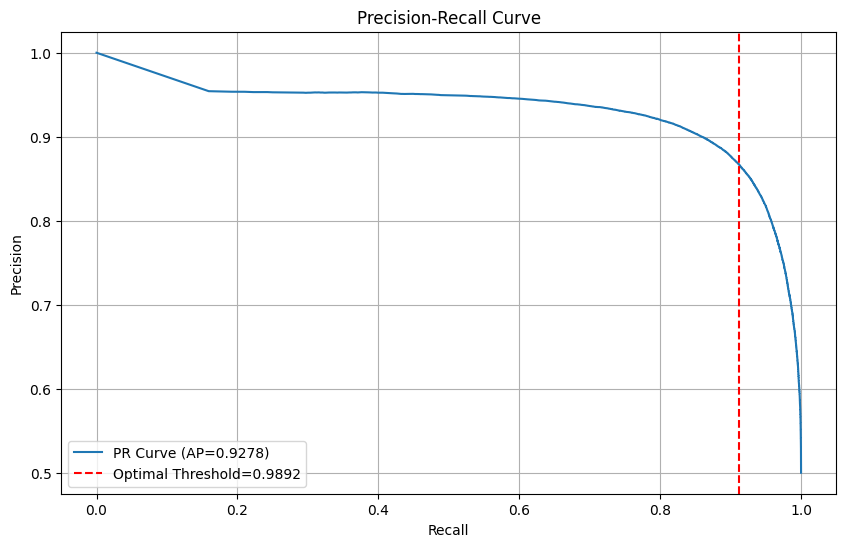

In [36]:
# Evaluate on test set
print("Evaluating on test set...")
test_results = evaluate_test_set_fastest(
    model, train_val_edge_index, test_df,
    fund_to_idx, stock_to_idx, num_nodes, DEVICE
)

# Top-K evaluation
print("\nEvaluating Top-K recommendations...")
top_k_results = evaluate_top_k_recommendations_fastest(
    model, train_val_edge_index, test_df,
    fund_to_idx, stock_to_idx, DEVICE, TOP_K_VALUES
)

# Find optimal threshold
print("\nFinding optimal threshold...")
optimal_threshold, _, _, _ = find_optimal_threshold_fastest(
    model, train_val_edge_index, test_df,
    fund_to_idx, stock_to_idx, num_nodes, DEVICE
)

### Step 11: Save Model (Optional)

In [ ]:
# Save model if configured
if SAVE_MODEL:
    save_path = Path(MODEL_SAVE_DIR)
    save_path.mkdir(parents=True, exist_ok=True)
    
    model_file = save_path / f"lightgcn_{TARGET_DATE}.pth"
    torch.save({
        'model_state_dict': model.state_dict(),
        'num_nodes': num_nodes,
        'embedding_dim': EMBEDDING_DIM,
        'num_layers': NUM_LAYERS,
        'fund_to_idx': fund_to_idx,
        'stock_to_idx': stock_to_idx,
        'target_date': TARGET_DATE,
        'test_results': test_results,
        'optimal_threshold': optimal_threshold
    }, model_file)
    print(f"✓ Model saved to: {model_file}")
else:
    print("Model saving disabled")

### Step 12: View Results and Visualizations

Final Results
AUC-ROC: 0.9460
Precision: 0.5010
Recall: 1.0000
F1 Score: 0.6675

Optimal Threshold: 0.9892

Top-K Results:
  K= 5: Hit Rate=0.3259, NDCG=0.0964
  K=10: Hit Rate=0.4999, NDCG=0.1094
  K=20: Hit Rate=0.6597, NDCG=0.1327
  K=50: Hit Rate=0.7870, NDCG=0.1776


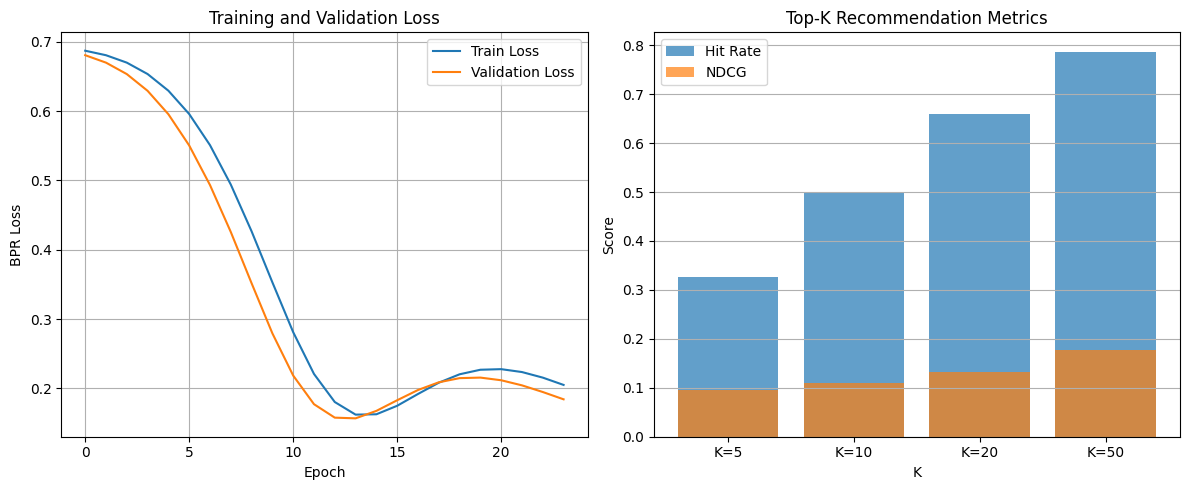

In [37]:
# Display results
print("="*60)
print("Final Results")
print("="*60)
print(f"AUC-ROC: {test_results['auc']:.4f}")
print(f"Precision: {test_results['precision']:.4f}")
print(f"Recall: {test_results['recall']:.4f}")
print(f"F1 Score: {test_results['f1']:.4f}")
print(f"\nOptimal Threshold: {optimal_threshold:.4f}")
print("\nTop-K Results:")
for k, metrics in top_k_results.items():
    print(f"  K={k:2d}: Hit Rate={metrics['hit_rate']:.4f}, NDCG={metrics['ndcg']:.4f}")

# Plot training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('BPR Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.bar([f'K={k}' for k in TOP_K_VALUES], 
        [top_k_results[k]['hit_rate'] for k in TOP_K_VALUES],
        alpha=0.7, label='Hit Rate')
plt.bar([f'K={k}' for k in TOP_K_VALUES], 
        [top_k_results[k]['ndcg'] for k in TOP_K_VALUES],
        alpha=0.7, label='NDCG')
plt.xlabel('K')
plt.ylabel('Score')
plt.title('Top-K Recommendation Metrics')
plt.legend()
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()

In [ ]:
### Step 2: Preprocess Data